def simulate_linspace(start, end, num_samples):
    if num_samples < 2:
        return [start] if num_samples == 1 else []

    step = (end - start) / (num_samples - 1)
    linspace_values = [start + i * step for i in range(num_samples)]
    return linspace_values

The entropy of the outcome is: 0.9915689713773178
The Gini index of the binned outcome is: 0.49416745106713444

The feature with the highest Information Gain (potential root node) is: fmri_feature_24
Information Gain value: 0.10593818329347793
Binned outcome (default parameters - equal width, 4 bins):
label
0    436
3    351
Name: count, dtype: int64

Binned fmri_feature_10 (frequency binning, 5 bins):
fmri_feature_10
4    158
0    158
2    157
3    157
1    157
Name: count, dtype: int64

Binned fmri_feature_14 (equal width binning, 3 bins):
fmri_feature_14
1    548
2    155
0     84
Name: count, dtype: int64
A6. Decision Tree Structure:
Split on feature: fmri_feature_24
|--- value: 0
    Split on feature: fmri_feature_71
    |--- value: 0
        Split on feature: fmri_feature_2
        |--- value: 0
            Predict: 1
        |--- value: 1
            Predict: 0
        |--- value: 2
            Predict: 1
        |--- value: 3
            Predict: 0
    |--- value: 1
        Pre

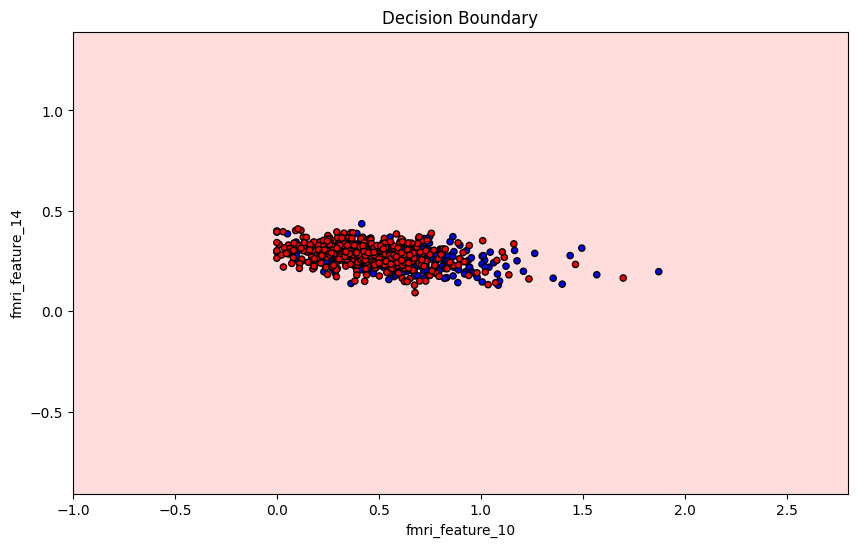

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the dataset
file_path = "/content/fmri_gap_cnn_extracted_features (1).csv"
df = pd.read_csv(file_path)

# Assuming the last column is the continuous outcome variable
outcome_column = df.iloc[:, -1]

# Store min/max values for binning during prediction
# In a real-world scenario, you would store these from the training data
# For this example, we'll use the min/max of the full dataset
feature_min_max = {col: (df[col].min(), df[col].max()) for col in df.columns if col.startswith('fmri_feature_')}


# Function for equal width binning
def custom_binning(data, num_bins=4, binning_type='equal_width', feature_name=None, feature_min_max=None):
    if data.empty or len(data) == 0:
        return pd.Series([], dtype=int)

    if binning_type == 'equal_width':
        if feature_min_max and feature_name in feature_min_max:
             min_val, max_val = feature_min_max[feature_name]
        else:
            min_val = data.min()
            max_val = data.max()
        # Add a small epsilon to max_val to ensure the maximum value is included
        bins = np.linspace(min_val, max_val + 1e-9, num_bins + 1)
        # Use duplicates='drop' to handle cases with non-unique bin edges
        binned_data = pd.cut(data, bins=bins, labels=False, include_lowest=True, duplicates='drop')
    elif binning_type == 'frequency':
        # Use qcut for frequency binning
        try:
            binned_data = pd.qcut(data, q=num_bins, labels=False, duplicates='drop')
        except ValueError:
            # Handle cases where qcut fails due to too few unique values
            binned_data = pd.cut(data, bins=num_bins, labels=False, include_lowest=True, duplicates='drop')
    else:
        print("Invalid binning_type. Choose 'equal_width' or 'frequency'.")
        return pd.Series([], dtype=int)

    return binned_data

# Function to calculate entropy
def calculate_entropy(data):
    if len(data) == 0:
        return 0
    value_counts = data.value_counts(normalize=True)
    # Add a small epsilon to avoid log(0)
    entropy = -np.sum(value_counts * np.log2(value_counts + 1e-9))
    return entropy


# Function to calculate Gini index
def calculate_gini_index(data):
    if len(data) == 0:
        return 0
    value_counts = data.value_counts(normalize=True)
    gini_index = 1 - np.sum(np.power(value_counts, 2))
    return gini_index

def calculate_information_gain_for_split(data, feature_column_name, target_column_name):
    total_entropy = calculate_entropy(data[target_column_name])

    weighted_entropy = 0
    # Iterate through the unique values (bins) in the binned feature
    for value in data[feature_column_name].unique():
        subset = data[data[feature_column_name] == value]
        subset_entropy = calculate_entropy(subset[target_column_name])
        weighted_entropy += (len(subset) / len(data)) * subset_entropy

    information_gain = total_entropy - weighted_entropy
    return information_gain


def find_best_split_for_continuous(data, feature_column, target_column_name, num_bins=4):
    # Create binned version of the continuous feature
    binned_feature = custom_binning(data[feature_column], num_bins)

    # Handle cases where binning might result in an empty Series
    if binned_feature.empty:
        return 0

    # Create a temporary DataFrame with the binned feature and the target
    temp_df = pd.DataFrame({
        'binned_feature': binned_feature,
        target_column_name: data[target_column_name]
    })

    # Calculate Information Gain using the binned feature
    # Ensure that 'binned_feature' is treated as a feature column and not the target
    info_gain = calculate_information_gain_for_split(temp_df, 'binned_feature', target_column_name)


    return info_gain

# A1.Write a function to calculate the entropy associated with your dataset.(If your dataset contains only continuous numeric data for outcome (a regression problem),
# employ equal width binning and divide your data into 4 bins. Each bin may be considered as a categorical data value. Write a function for equal width binning).
# Calculate the entropy of the outcome (the outcome of my data set consists of 0 or 1, which is not a continous outcome)
entropy_value = calculate_entropy(outcome_column)
print(f"The entropy of the outcome is: {entropy_value}")

# A2. Calculate the Gini index value for your dataset.
# Calculate the Gini index of the binned outcome
gini_value = calculate_gini_index(outcome_column)
print(f"The Gini index of the binned outcome is: {gini_value}")

# A3. Write your own module for detecting the feature / attribute for the root note of a Decision Tree.
# Use Information gain as the impurity measure for identifying the root node. Assume that the features are categorical or could be converted to categorical by binning.
information_gains = {}
feature_values = df.columns[1:-1] # Define feature_values for the original dataframe
target_column_name = df.columns[-1]
for feature in feature_values:
    if feature.startswith("fmri_feature_"):
      info_gain = find_best_split_for_continuous(df, feature, target_column_name, num_bins=4)
      information_gains[feature] = info_gain


if information_gains:
    root_node_feature = max(information_gains, key=information_gains.get)
    print(f"\nThe feature with the highest Information Gain (potential root node) is: {root_node_feature}")
    print(f"Information Gain value: {information_gains[root_node_feature]}")
else:
    print("\nNo Information Gains were calculated for the specified features.")

# A4. If the feature is continuous valued for A3, use equal width or frequency binning for converting the attribute to categorical valued. The binning type should be a parameter to the function built for binning. Write your own function for the binning task. The number of bins to be created should also be passed as a parameter to the function. Use function overloading to allow for usage of default parameters if no parameters are passed.
# Example usage with default parameters (equal width, 4 bins)
binned_outcome_default = custom_binning(df['label'])
print("Binned outcome (default parameters - equal width, 4 bins):")
print(binned_outcome_default.value_counts())

# Example usage with specified parameters (frequency, 5 bins)
binned_feature_freq = custom_binning(df['fmri_feature_10'], num_bins=5, binning_type='frequency')
print("\nBinned fmri_feature_10 (frequency binning, 5 bins):")
print(binned_feature_freq.value_counts())

# Example usage with specified parameters (equal width, 3 bins)
binned_feature_width = custom_binning(df['fmri_feature_14'], num_bins=3, binning_type='equal_width')
print("\nBinned fmri_feature_14 (equal width binning, 3 bins):")
print(binned_feature_width.value_counts())

# A5. Expand the above functions to build your own Decision Tree module.
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_leaf=5):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        self.feature_min_max_ = {} # Store min/max for binning during prediction
        self.global_majority_class = None # Store the majority class of the entire dataset

    def _find_best_split(self, df, target_column):
        best_feature = None
        max_info_gain = -1

        features = [col for col in df.columns if col != target_column]

        for feature in features:
            # Assuming all features are continuous for this problem
            info_gain = find_best_split_for_continuous(df, feature, target_column)
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_feature = feature
        return best_feature

    def _grow_tree(self, df, target_column, depth):
        # Stopping conditions
        if depth >= self.max_depth or len(df) < self.min_samples_leaf or len(df[target_column].unique()) == 1:
            if not df.empty:
                leaf_value = df[target_column].mode()[0]
            else:
                leaf_value = self.global_majority_class # Use global majority if subset is empty
            return {'leaf_value': leaf_value}

        best_feature = self._find_best_split(df, target_column)

        if best_feature is None:
            if not df.empty:
                leaf_value = df[target_column].mode()[0]
            else:
                leaf_value = self.global_majority_class # Use global majority if subset is empty
            return {'leaf_value': leaf_value}

        tree = {'feature': best_feature, 'children': {}}
        # Store min/max of the feature for consistent binning during prediction
        self.feature_min_max_[best_feature] = (df[best_feature].min(), df[best_feature].max())
        binned_feature = custom_binning(df[best_feature], feature_name=best_feature, feature_min_max=self.feature_min_max_)


        for value in sorted(binned_feature.unique()):
            subset = df[binned_feature == value]
            if not subset.empty:
                tree['children'][value] = self._grow_tree(subset.drop(columns=[best_feature]), target_column, depth + 1)
        return tree

    def fit(self, X, y):
        df = X.copy()
        df['target'] = y
        self.global_majority_class = y.mode()[0] # Calculate global majority class
        self.tree = self._grow_tree(df, 'target', 0)


    def _predict_single(self, x, tree):
        if 'leaf_value' in tree:
            return tree['leaf_value']

        feature = tree['feature']

        # Bin the feature value of the input sample using stored min/max from training
        if feature in self.feature_min_max_:
            binned_value_series = custom_binning(pd.Series([x[feature]]), feature_name=feature, feature_min_max=self.feature_min_max_)
            if not binned_value_series.empty:
                 binned_value = binned_value_series.iloc[0]
            else:
                # If binning results in empty series, return global majority
                return self.global_majority_class
        else:
             # If feature not in stored min/max, cannot bin, return global majority
             return self.global_majority_class


        if binned_value in tree['children']:
            return self._predict_single(x, tree['children'][binned_value])
        else:
            # If a bin was not seen during training for this feature split
            # Return the majority class of the parent node if available,
            # otherwise, traverse up or return the global majority.
            # For simplicity here, we return the global majority.
            return self.global_majority_class


    def predict(self, X):
        return [self._predict_single(x, self.tree) for _, x in X.iterrows()]

# A6. Draw and visualize the decision tree
def print_tree(tree, indent=""):
    if 'leaf_value' in tree:
        print(indent + "Predict:", tree['leaf_value'])
        return
    print(indent + "Split on feature:", tree['feature'])
    for value, subtree in tree['children'].items():
        print(indent + "|--- value:", value)
        print_tree(subtree, indent + "    ")

# Prepare data for the decision tree
X = df.drop(columns=['label'])
y = df['label']

# Create and fit the decision tree
dt = DecisionTree(max_depth=3, min_samples_leaf=10)
dt.fit(X, y)

# Visualize the tree
print("A6. Decision Tree Structure:")
print_tree(dt.tree)


# A7. Visualize the decision boundary
def plot_decision_boundary(X, y, model, feature1, feature2):
    X_subset = X[[feature1, feature2]]
    y_subset = y.values

    # Create a meshgrid
    x_min, x_max = X_subset.iloc[:, 0].min() - 1, X_subset.iloc[:, 0].max() + 1
    y_min, y_max = X_subset.iloc[:, 1].min() - 1, X_subset.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Create a DataFrame for prediction with all columns initialized
    grid_data = {}
    for col in X.columns:
         if col in [feature1, feature2]:
              continue
         grid_data[col] = [X[col].mean()] * len(xx.ravel()) # Use the mean for other features


    grid_df = pd.DataFrame(grid_data)
    grid_df[feature1] = xx.ravel()
    grid_df[feature2] = yy.ravel()


    # Predict on the grid
    Z = np.array(model.predict(grid_df))
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    plt.scatter(X_subset.iloc[:, 0], X_subset.iloc[:, 1], c=y_subset, s=20, edgecolor='k', cmap=cmap_bold)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title("Decision Boundary")
    plt.show()

# Select two features for visualization
feature1 = 'fmri_feature_10'
feature2 = 'fmri_feature_14'

# Create a new tree instance and fit it on the two selected features
# Note: For accurate visualization of the decision boundary based on *only* two features,
# you should train the tree on a dataset containing only those two features.
# The current implementation trains the tree on the full dataset and then
# attempts to visualize the boundary using only two features while holding others constant.
# This might not perfectly represent the decision boundaries of the full tree.
# To visualize the boundary of a tree trained on the full dataset in a 2D plot,
# you would typically fix the values of all other features. The current approach
# approximates this by setting other features to their means.
# We will use the original tree 'dt' for visualization as requested.


print("\nA7. Visualizing the Decision Boundary:")
# Plot the decision boundary for the two selected features using the original tree 'dt'
plot_decision_boundary(X, y, dt, feature1, feature2)